## 1. 데이터처리

In [1]:
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import json
import time

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm_notebook

In [4]:
X_train = pd.read_csv('/content/drive/MyDrive/악성댓글_필터링_봇_모델/01_Machine_Learning/data/X_train.csv', index_col=[0])
X_test = pd.read_csv('/content/drive/MyDrive/악성댓글_필터링_봇_모델/01_Machine_Learning/data/X_test.csv', index_col=[0])
y_train = pd.read_csv('/content/drive/MyDrive/악성댓글_필터링_봇_모델/01_Machine_Learning/data/y_train.csv', index_col=[0])
y_test = pd.read_csv('/content/drive/MyDrive/악성댓글_필터링_봇_모델/01_Machine_Learning/data/y_test.csv', index_col=[0])

word_index_json = open('/content/drive/MyDrive/악성댓글_필터링_봇_모델/01_Machine_Learning/data/word_index_vocab.json', 'r').read()
word_index_vocab = json.loads(word_index_json)

In [5]:
X_train_split = X_train['댓글'].apply(list).tolist()
X_test_split = X_test['댓글'].apply(list).tolist()

In [6]:
tokenizer = Tokenizer()
tokenizer.word_index = word_index_vocab

X_train_sequences = tokenizer.texts_to_sequences(X_train_split)
X_test_sequences = tokenizer.texts_to_sequences(X_test_split)

In [7]:
train = pad_sequences(X_train_sequences, padding='post', maxlen=400)
test = pad_sequences(X_test_sequences, padding='post', maxlen=400)

In [8]:
y_train.value_counts()

악플여부
0       56179
1       35676
dtype: int64

In [ ]:
# from imblearn.over_sampling import SMOTE

In [ ]:
# start = time.time()

# smote = SMOTE(random_state=123)
# train_over, y_train_over = smote.fit_sample(train, y_train)

# print("걸린시간 :", time.time() - start)

걸린시간 : 261.47045040130615


## 2. Naive Bayse

In [9]:
train_over = train
y_train_over = y_train

In [10]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV

In [11]:
NB = BernoulliNB()
NB.fit(train_over, y_train_over)
y_class = NB.predict(test)
y_prob = NB.predict_proba(test)[:,1]


# 3. 모델평가(AUC수치)

In [12]:
y = np.array(y_test)

In [13]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, make_scorer
import matplotlib.pyplot as plt

AUC는? : 0.5432551


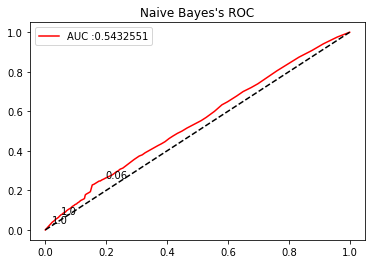

In [14]:
# Threshold변화에 따른 fpr, tpr의 변화
fpr_array, tpr_array, threshold_array = roc_curve(y, y_prob)

# 그래프에 threshold를 표시하기위해 인덱스 추출
idx_list = np.arange(1, len(threshold_array), 50)


# ROC 그래프 그리기
plt.plot(fpr_array, tpr_array, 
         c = 'red', 
         label = "AUC :" + str(round(roc_auc_score(y, y_prob), 7)))
plt.plot([0, 1], [0,1], ls='--', c='black')
plt.title("Naive Bayes's ROC")
plt.legend(loc=0)
for idx in idx_list:
    text = str(round(threshold_array[idx], 2))
    plt.text(fpr_array[idx], tpr_array[idx], text)


# ROC의 auc는?
print('AUC는? :', round(roc_auc_score(y, y_prob), 7))

## 4. ROC그래프를 그리기 위해 저장

In [17]:
data = {
    'fpr_array'       : fpr_array,
    'tpr_array'       : tpr_array,
    'threshold_array' : threshold_array
}

df = pd.DataFrame(data)
df.to_csv('/content/drive/MyDrive/악성댓글_필터링_봇_모델/03_ROC_그래프/Naive_bayse_ROC.csv')

# 5. 모델저장

In [15]:
import pickle
from sklearn.externals import joblib

In [16]:
joblib.dump(NB, 'Bernoulli_naive_bayes.pkl')

['Bernoulli_naive_bayes.pkl']

In [ ]:
def model_test(comment):
    loaded_model = joblib.load('Bernoulli_naive_bayes.pkl')
    comment_list = [list(comment)]
    comment_label = tokenizer.texts_to_sequences(comment_list)

    comment_pad = pad_sequences(comment_label, padding='post', maxlen=400)

    pred = loaded_model.predict_proba(comment_pad)[:, 1]

    if pred < 0.5 :
        result = '악플이 아닙니다'
    else :
        result = '악플입니다'
    
    print(result)
    print('라벨확률 : ', pred)
    
    return result, pred

In [ ]:
comment = '''병신아'''

result, prob = model_test(comment)

악플이 아닙니다
라벨확률 :  [0.13372898]
